In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedShuffleSplit 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets, models
import torch.nn.functional as F
import time

In [2]:
SEED = 42
TRAIN_SUBSET_SIZE = 8000 
VAL_SUBSET_SIZE = 2000 
TSNE_SAMPLES = 2000 
BATCH_SIZE = 128
EPOCHS_MLP = 8
EPOCHS_CNN = 8
np.random.seed(SEED)
torch.manual_seed(SEED)



Training MLP...
Epoch 1 loss = 0.2580
Epoch 2 loss = 0.2136
Epoch 3 loss = 0.3701
Epoch 4 loss = 0.2972
Epoch 5 loss = 0.0921
MLP Accuracy: 0.957
MLP F1 Score: 0.9564779243827205
MLP Confusion Matrix:
 [[ 963    0    1    2    0    2    5    4    2    1]
 [   0 1122    2    2    0    1    3    1    4    0]
 [   8    2  968   13   10    1    6   13   11    0]
 [   0    0    4  981    0    2    0   10   11    2]
 [   2    0    5    0  946    0    5    4    3   17]
 [   5    1    0   26    4  812   13    3   22    6]
 [   6    3    3    0    7    4  929    0    6    0]
 [   0    7   12    7    3    1    0  987    2    9]
 [   5    3    4   17    4    4    6   11  918    2]
 [   3    7    0   11   23    5    0   12    4  944]]

Training baseline models...

Random Forest Accuracy: 0.9701
Random Forest F1: 0.9698568194123499
Random Forest Confusion:
 [[ 972    0    0    0    0    3    1    1    3    0]
 [   0 1124    2    2    0    2    3    1    1    0]
 [   5    0 1002    5    2    0    3 

C:\Users\Anurudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Accuracy: 0.9218
Logistic Regression F1: 0.9206480157991278
Logistic Regression Confusion:
 [[ 955    0    1    4    1    6    7    2    4    0]
 [   0 1113    8    2    0    1    3    1    7    0]
 [   3   12  917   18   12    6   13    9   38    4]
 [   4    2   18  922    2   24    3    9   19    7]
 [   2    3    5    4  916    0   10    5    9   28]
 [  12    4    4   37   11  761   15    8   34    6]
 [  10    3    8    2    6   18  907    1    2    1]
 [   1    7   25   10    6    1    0  943    3   32]
 [   7   13    6   23    8   22    6   13  865   11]
 [   8    6    2   11   24    4    0   22   13  919]]


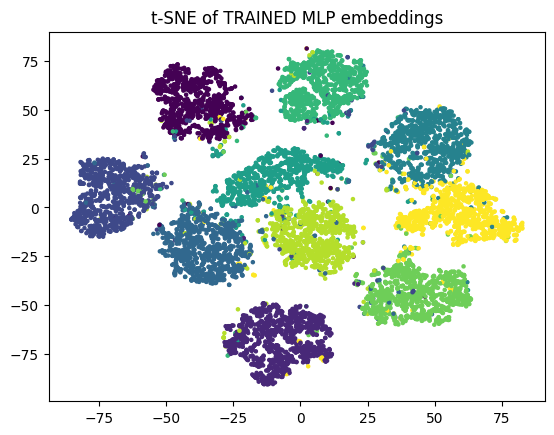


Testing trained MLP on Fashion-MNIST...
Accuracy on Fashion-MNIST : 0.1151


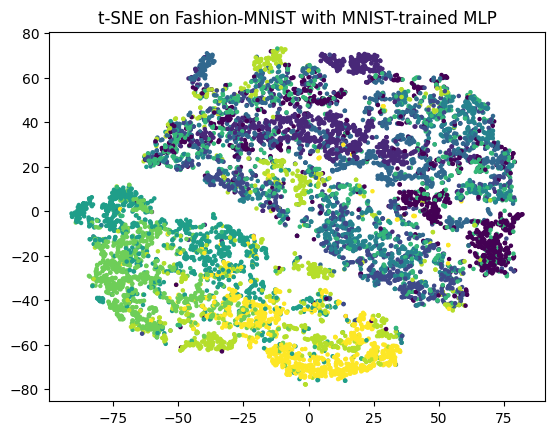

In [5]:

# DATA LOADING
# --------------------------------------------
transform = transforms.ToTensor()

mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
mnist_test  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

fashion_test = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader  = DataLoader(mnist_test, batch_size=64, shuffle=False)
fashion_loader = DataLoader(fashion_test, batch_size=64, shuffle=False)


# MLP
# --------------------------------------------
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)    
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        middle = torch.relu(self.fc2(x))
        out = self.fc3(middle)
        return out, middle   # return embedding


mlp = SimpleMLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.001)


# MLP TRAIN
# --------------------------------------------
print("Training MLP...")
for epoch in range(5):
    for images, labels in train_loader:
        output, _ = mlp(images)
        loss = loss_fn(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} loss = {loss.item():.4f}")



# MLP TEST
# --------------------------------------------
mlp_preds = []
mlp_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        output, _ = mlp(images)
        pred = output.argmax(dim=1)
        mlp_preds.extend(pred.tolist())
        mlp_labels.extend(labels.tolist())

mlp_acc = accuracy_score(mlp_labels, mlp_preds)
mlp_f1 = f1_score(mlp_labels, mlp_preds, average="macro")
print("MLP Accuracy:", mlp_acc)
print("MLP F1 Score:", mlp_f1)
print("MLP Confusion Matrix:\n", confusion_matrix(mlp_labels, mlp_preds))


# BASELINE MODELS (Sklearn)
# --------------------------------------------
print("\nTraining baseline models...")

flatten_train = mnist_train.data.view(-1, 28*28).float()
flatten_test  = mnist_test.data.view(-1, 28*28).float()

# Random Forest
forest = RandomForestClassifier(n_estimators=100)
forest.fit(flatten_train, mnist_train.targets)
forest_pred = forest.predict(flatten_test)

print("\nRandom Forest Accuracy:", accuracy_score(mnist_test.targets, forest_pred))
print("Random Forest F1:", f1_score(mnist_test.targets, forest_pred, average="macro"))
print("Random Forest Confusion:\n", confusion_matrix(mnist_test.targets, forest_pred))

# Logistic Regression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(flatten_train, mnist_train.targets)
log_pred = log_reg.predict(flatten_test)

print("\nLogistic Regression Accuracy:", accuracy_score(mnist_test.targets, log_pred))
print("Logistic Regression F1:", f1_score(mnist_test.targets, log_pred, average="macro"))
print("Logistic Regression Confusion:\n", confusion_matrix(mnist_test.targets, log_pred))



# t-SNE VISUALIZATION
# --------------------------------------------
def extract_embeddings(model, loader):
    all_emb = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            _, emb = model(images)
            all_emb.append(emb)
            all_labels.extend(labels.tolist())
    return torch.cat(all_emb).numpy(), np.array(all_labels)


# Get embeddings
trained_emb, trained_labels = extract_embeddings(mlp, test_loader)

# Fake "untrained" model to compare
untrained = SimpleMLP()
untrained_emb, _ = extract_embeddings(untrained, test_loader)

# t-SNE plot
tsne = TSNE(n_components=2)
trained_2d = tsne.fit_transform(trained_emb)

plt.figure()
plt.scatter(trained_2d[:,0], trained_2d[:,1], c=trained_labels, s=5)
plt.title("t-SNE of TRAINED MLP embeddings")
plt.show()


# CROSS-DOMAIN TEST ON FASHION-MNIST
# --------------------------------------------
print("\nTesting trained MLP on Fashion-MNIST...")
fashion_preds = []
fashion_lbls = []

with torch.no_grad():
    for images, labels in fashion_loader:
        out, _ = mlp(images)
        pred = out.argmax(dim=1)
        fashion_preds.extend(pred.tolist())
        fashion_lbls.extend(labels.tolist())

print("Accuracy on Fashion-MNIST :", accuracy_score(fashion_lbls, fashion_preds))

# embeddings for visualization
fashion_emb, fashion_lbls = extract_embeddings(mlp, fashion_loader)
fashion_2d = TSNE(n_components=2).fit_transform(fashion_emb)

plt.figure()
plt.scatter(fashion_2d[:,0], fashion_2d[:,1], c=fashion_lbls, s=5)
plt.title("t-SNE on Fashion-MNIST with MNIST-trained MLP")
plt.show()




In [6]:

import time

#  CNN 
# ---------------------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32*13*13, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(-1, 32*13*13)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# TRAIN THE SIMPLE CNN
# ---------------------------------------------------------
cnn = SimpleCNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

print("\nTraining Simple CNN...")
for epoch in range(3):
    for images, labels in train_loader:
        output = cnn(images)
        loss = loss_fn(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} Loss = {loss.item():.4f}")



# METRIC CALCULATION FUNCTION
# ---------------------------------------------------------
def evaluate_model(model, loader):
    preds, labs = [], []
    start_time = time.time()

    with torch.no_grad():
        for images, labels in loader:
            out = model(images)
            pred = out.argmax(dim=1)
            preds.extend(pred.tolist())
            labs.extend(labels.tolist())

    return (
        accuracy_score(labs, preds),
        f1_score(labs, preds, average='macro'),
        confusion_matrix(labs, preds),
        time.time() - start_time
    )


cnn_acc, cnn_f1, cnn_conf, cnn_time = evaluate_model(cnn, test_loader)



# PRETRAINED MODELS 
# ---------------------------------------------------------
# Pretrained models expect RGB 224x224 input
pre_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

pretest_data = datasets.MNIST(root="./data", train=False, download=True, transform=pre_transform)
pretest_loader = DataLoader(pretest_data, batch_size=32, shuffle=False)

alexnet  = models.alexnet(pretrained=True)
mobilenet = models.mobilenet_v2(pretrained=True)

alexnet.eval()
mobilenet.eval()



# EVALUATE PRETRAINED MODELS
# ---------------------------------------------------------
alex_acc, alex_f1, alex_conf, alex_time = evaluate_model(alexnet, pretest_loader)
mob_acc, mob_f1, mob_conf, mob_time = evaluate_model(mobilenet, pretest_loader)


# PARAMETER COUNT FUNCTION
# ---------------------------------------------------------
def count_params(model):
    return sum(p.numel() for p in model.parameters())

cnn_params  = count_params(cnn)
alex_params = count_params(alexnet)
mob_params  = count_params(mobilenet)



# PRINT RESULTS
# ---------------------------------------------------------
print("\n==================== RESULTS ====================\n")

print("=== Simple CNN (trained on MNIST) ===")
print("Accuracy:", cnn_acc)
print("F1 Score:", cnn_f1)
print("Parameters:", cnn_params)
print("Inference Time (s):", cnn_time)
print("Confusion Matrix:\n", cnn_conf)

print("\n=== AlexNet (pretrained on ImageNet) ===")
print("Accuracy:", alex_acc)
print("F1 Score:", alex_f1)
print("Parameters:", alex_params)
print("Inference Time (s):", alex_time)
print("Confusion Matrix:\n", alex_conf)

print("\n=== MobileNetV2 (pretrained on ImageNet) ===")
print("Accuracy:", mob_acc)
print("F1 Score:", mob_f1)
print("Parameters:", mob_params)
print("Inference Time (s):", mob_time)
print("Confusion Matrix:\n", mob_conf)



Training Simple CNN...
Epoch 1 Loss = 0.0350
Epoch 2 Loss = 0.0667
Epoch 3 Loss = 0.1095


C:\Users\Anurudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Anurudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Anurudh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: Us


==================== RESULTS ====================

=== Simple CNN (trained on MNIST) ===
Accuracy: 0.9836
F1 Score: 0.9835311097812032
Parameters: 693962
Inference Time (s): 3.2461323738098145
Confusion Matrix:
 [[ 971    0    2    0    0    1    2    2    1    1]
 [   0 1130    4    0    0    0    0    1    0    0]
 [   2    5 1009    0    1    0    1   13    1    0]
 [   0    0    1  999    0    2    0    5    2    1]
 [   0    0    4    0  970    0    0    1    1    6]
 [   2    1    0    8    0  872    6    0    3    0]
 [   6    3    1    0    3    3  940    0    2    0]
 [   0    1    6    1    0    0    0 1019    1    0]
 [   6    0    4    2    2    1    1    6  946    6]
 [   0    4    1    2    8    3    0   11    0  980]]

=== AlexNet (pretrained on ImageNet) ===
Accuracy: 0.0
F1 Score: 0.0
Parameters: 61100840
Inference Time (s): 213.71129488945007
Confusion Matrix:
 [[ 0  0  0 ...  0 96  0]
 [ 0  0  0 ...  0  0  1]
 [ 0  0  0 ...  0 37 40]
 ...
 [ 0  0  0 ...  0  0  0]
 [